In [1]:

import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
from scipy.signal import find_peaks

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

## Load the Bed Profile

dx: 2.1162324649298596 cm
nx 500


Text(0, 0.5, 'z (m)')

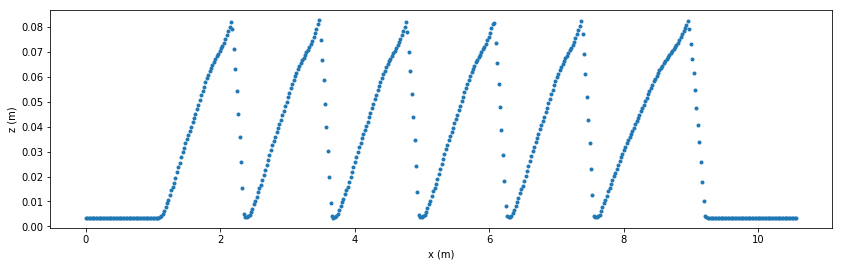

In [47]:
filepath = 'dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 500)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## Load the flow properties

In [48]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

## 20 cm Flow Case - Stage 2 

Note that the flow properties for Stage 2 are based on the equilibrium dunes after some period and not after the inital change in flow depth. Therefore these cannot be used for calibration.

Qc = 0.02 $m^3/s$

h2 = 0.16 m

uavg = 0.484 m/s

qin  0.07894736842105263
num_dim: 1
2019-05-21 23:22:01,897 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-21 23:22:02,626 INFO CLAW: Solution 1 computed for time t=30.000000
2019-05-21 23:22:03,254 INFO CLAW: Solution 2 computed for time t=60.000000
2019-05-21 23:22:03,914 INFO CLAW: Solution 3 computed for time t=90.000000
2019-05-21 23:22:04,601 INFO CLAW: Solution 4 computed for time t=120.000000
2019-05-21 23:22:05,267 INFO CLAW: Solution 5 computed for time t=150.000000
2019-05-21 23:22:06,098 INFO CLAW: Solution 6 computed for time t=180.000000
2019-05-21 23:22:06,883 INFO CLAW: Solution 7 computed for time t=210.000000
2019-05-21 23:22:07,536 INFO CLAW: Solution 8 computed for time t=240.000000
2019-05-21 23:22:08,167 INFO CLAW: Solution 9 computed for time t=270.000000
2019-05-21 23:22:08,804 INFO CLAW: Solution 10 computed for time t=300.000000
Elevation at outlet
Mean U: 0.41538341117339556
Surface: 0.22921192513220426


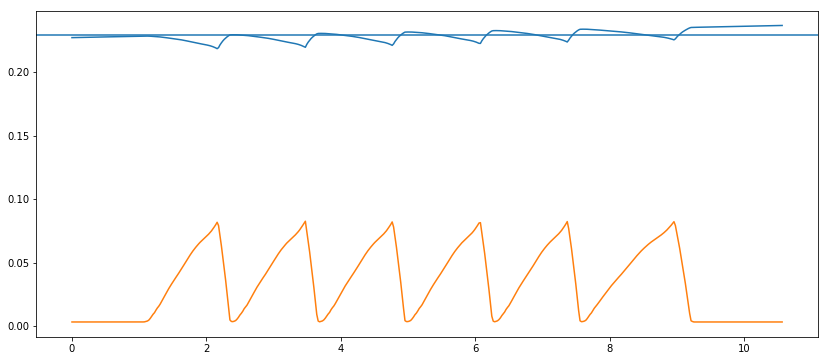

In [49]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, q20cm)
model.set_controller(tfinal = 300, num_output_times=10)
model.run()

h = model.get_hf()
surf = h + z0
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf)
plt.plot(x0, z0)


print('Elevation at outlet'.format(surf[len(x0)-1]))
print('Mean U: {0}'.format(model.get_uf().mean()))
print('Surface: {0}'.format(surf.mean()))
plt.axhline(surf.mean())

## 32 cm Flow Case - Stage 1 

Qc = 0.0455 $m^3/s$

h2 = 0.32 m

uavg = 0.561 m/s

qin  0.17960526315789474
num_dim: 1
2019-05-21 23:22:09,118 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-21 23:22:09,953 INFO CLAW: Solution 1 computed for time t=30.000000
2019-05-21 23:22:10,785 INFO CLAW: Solution 2 computed for time t=60.000000
2019-05-21 23:22:11,672 INFO CLAW: Solution 3 computed for time t=90.000000
2019-05-21 23:22:12,477 INFO CLAW: Solution 4 computed for time t=120.000000
2019-05-21 23:22:13,353 INFO CLAW: Solution 5 computed for time t=150.000000
2019-05-21 23:22:14,207 INFO CLAW: Solution 6 computed for time t=180.000000
2019-05-21 23:22:15,152 INFO CLAW: Solution 7 computed for time t=210.000000
2019-05-21 23:22:16,006 INFO CLAW: Solution 8 computed for time t=240.000000
2019-05-21 23:22:16,848 INFO CLAW: Solution 9 computed for time t=270.000000
2019-05-21 23:22:17,665 INFO CLAW: Solution 10 computed for time t=300.000000
Elevation at outlet
Mean U: 0.5774477304821313
Surface: 0.34830565296544247


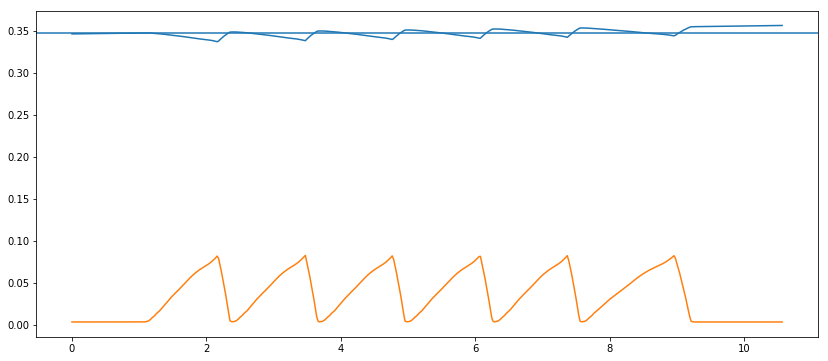

In [50]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut32, 0.0)
model.set_controller(tfinal = 300, num_output_times=10)
model.run()

h = model.get_hf()
surf = h + z0

fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf)
plt.plot(x0, z0)


print('Elevation at outlet'.format(surf[len(x0)-1]))
print('Mean U: {0}'.format(model.get_uf().mean()))
print('Surface: {0}'.format(surf.mean()))
plt.axhline(surf.mean())

In [51]:
# https://project.inria.fr/medlagoon/files/2012/11/TesiSWE_Cinat.pdf

def get_top_peaks(z, dx):
    top_peaks, _ = find_peaks(z, height = z.mean()*1.1, distance = int(0.5/dx))
    return top_peaks

def get_bottom_indexes(z,crest_indexes, dx):
    bottom_indexes = []
    
    for crest_index in crest_indexes:
    
        index_end = crest_index + int(0.5*1.3/dx) 
        minZ = np.amin(z[crest_index : index_end])
        lowPoints = np.where(z == minZ)[0]

        index = np.where(lowPoints > crest_index)[0][0]
        index = lowPoints[index]
        bottom_indexes.append(index)
        
    return np.array(bottom_indexes)
    
    
    
def calculate_bedload(h, u, x, z):
    qbedload = np.zeros(len(x))
    a = 0.001
    b = 3
    qbedload = (a*u*(u) **(b-1.))
    return qbedload

 

def get_recirculation_indexes(x, z):
    
    dx = x[2] - x[1]
    crest_indexes = get_top_peaks(z, dx)
    bottom_indexes = get_bottom_indexes(z, crest_indexes, dx)    
    
    recirculation_indexes = []
    for i in range(len(crest_indexes)):
              
        height = z[crest_indexes[i]] - z[bottom_indexes[i]]        
        xreattachment = (5.* height) + x[crest_indexes[i]]
        
        index = bottom_indexes[i]
        while index < len(x) and x[index] < xreattachment:
            index += 1
                
        recirculation_indexes.append(index)
    
    return np.array(recirculation_indexes)

def modify_bedload(crest_indexes, base_indexes, reattachment_indexes, qb, x):
    qb_new = qb.copy()
    for i in range(len(crest_indexes)):
        
        qsb_reattachment = qb[reattachment_indexes[i]]
        
        if i+1 < len(crest_indexes):
            for j in range(crest_indexes[i]+1, reattachment_indexes[i]):
                qb_new[j] = qb[j] - qsb_reattachment
            
            for j in range(reattachment_indexes[i], crest_indexes[i+1]):
                qb_new[j] = qb[j]*(x[j] - x[reattachment_indexes[i]] )**0.1/(x[crest_indexes[i+1]] - x[reattachment_indexes[i]])**0.1
                
    return qb_new

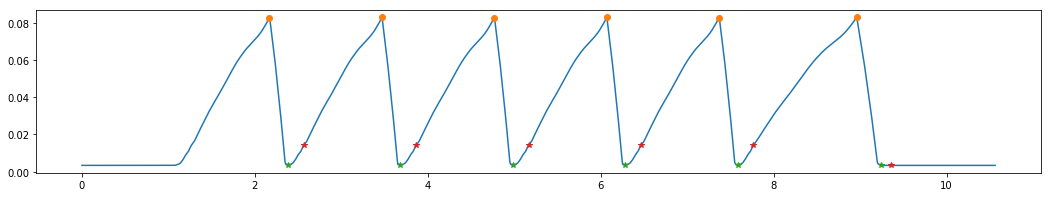

In [27]:
qsb = calculate_bedload(model.get_hf(), model.get_uf(), x0, z0)

dx = x0[2] - x0[1]

top_indexes = get_top_peaks(z0, dx)
bottom_indexes = get_bottom_indexes(z0, top_indexes, dx)

rindexes = get_recirculation_indexes(x0,z0)

fig = plt.figure(figsize=(18, 3))
#plt.plot(x0, qsb)
plt.plot(x0, z0)
plt.plot(x0[top_indexes], z0[top_indexes], 'o')
plt.plot(x0[bottom_indexes], z0[bottom_indexes], '*')

plt.plot(x0[rindexes], z0[rindexes], '*')


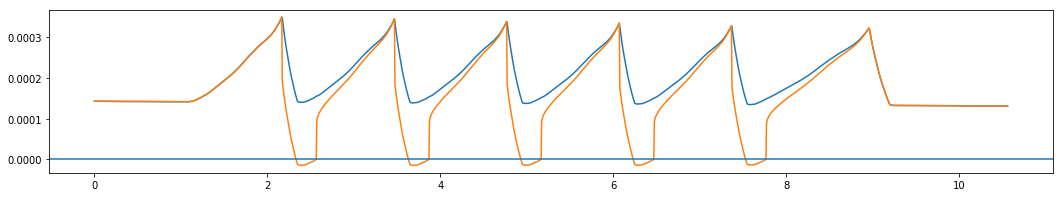

In [28]:
'''def modify_bedload(crest_indexes, base_indexes, reattachment_indexes, qb, x):
    qb_new = qb.copy()
    for i in range(len(crest_indexes)):
        
        for j in range(crest_indexes[i]+1, base_indexes[i]):
            qb_new[j] = -1.*qb[j] * (x[base_indexes[i]] - x[j])/(x[base_indexes[i]] - x[crest_indexes[i]])
            
        for j in range(base_indexes[i]+1, reattachment_indexes[i]):
            qb_new[j] = -1.*qb[j] * (x[base_indexes[i]] - x[j])/(x[base_indexes[i]] - x[crest_indexes[i]])
        
    return qb_new'''




crest_indexes = get_top_peaks(z0, dx)
base_indexes = get_bottom_indexes(z0, crest_indexes, dx)

reattachment_indexes = get_recirculation_indexes(x0,z0)

qsb = calculate_bedload(model.get_hf(), model.get_uf(), x0, z0)

qsb_new = modify_bedload(crest_indexes, base_indexes, reattachment_indexes, qsb, x0)


fig = plt.figure(figsize=(18, 3))
plt.plot(x0, qsb)
plt.plot(x0, qsb_new)
plt.axhline(y = 0.0)

In [29]:
crest_indexes, np.array(base_indexes), reattachment_indexes

(array([ 369,  591,  812, 1034, 1255, 1526]),
 array([ 406,  627,  849, 1070, 1292, 1575]),
 array([ 437,  659,  880, 1102, 1323, 1594]))